#  <center>ESS 136, Lab 3</center> 
## <center> Seismic Refraction </center>
### <center> Due Feb 4, 2020, 17:00 </center>

## 1. Introduction
The objective of this lab is to analyze the seismic data from the geophone array centered on
the Emerson fault near the Landers earthquake. You will use the forward and reverse shots across
the geophone line to pick the first arrivals and try fitting the data with 2 different models: 1)
Dipping interface 2) Faulted interface. Details of the 2 interfaces can be found in the book
Looking into the Earth: An Introduction to Geological Geophysics (page 71 and 81). We tried to
structure the process as easy as running the consecutive files step1-step2-step3-step4-
FaultRefract-hagedoorn2 for Matlab data processing.

## 2. Dipping interface
Start by download the zip file LAB03.zip under week 4 on CCLE.
For the dipping layer model, run step1.m, step2.m, step3.m and step4.m one by one.

### 1. To use our seismic data to determine the seismic velocities and the depths of our layers, we
first need to pick our first arrivals and create what is called a Slowness diagram, which plots the
time of the first arrival (on the y axis) vs. the distance to the station at which the first arrival is
recorded. It’s called a slowness diagram, because the axes are inverted relative to the orientation
of a velocity diagram, and the slope is therefore the inverse of velocity. This means that steeper
slopes correspond to lower velocities.

The data is prepared such that by simply running step1.m and step2.m you should be able to
automatically create the vectors tt1 and tt2 containing your first arrivals and the geophone
numbers for the forward and reverse shots respectively. However, some seismograms we recorded
are so noisy that it might be difficult for us to pick the accurate first arrival time. In this case,
please refer to the seismograms next to them and try to make the curve smooth.

### 2. Run step3.m. 
This will plot a slowness diagram of your forward and reverse shots using tt1
first and then tt2. Select 2 branches corresponding to different slopes with mouse clicks. Make
sure the lines satisfy the reciprocity property: wave traveling time is the same for the forward
and reverse shots (i.e. the line length). You probably will repeat this step many times. This
depends on how the Refraction Interpretation figure in the next step would look like. The blue
stars are the first arrival picks from the forward model, and the lines will attempt to fit the data.
The red stars are the first arrival picks from the reverse model, and the lines attempt to fit the
data.

### 3. Run step4.m. This will plot the Refraction Interpretation calculating the velocities and
thicknesses of each layer beneath the receivers. You should get the layers that don’t intersect. The
depths and velocities values at the top you will use later.

## 3. Faulted interface
For the faulted interface model, simply run the script FaultRefract.m.
Similar to the gravity labs, we want the model fit the data better by tuning some parameters in the
model. There are 5 parameters we need to adjust in this case: h1, h2, v1, v2 and xc. You can use
the results of the dipping layer model as initial guess for h1, h2, v1 and v2.

## 4. Hagedoorn model.
Run Hagedoorn2.m to calculate the interface depth and velocity using the Hagedoorn/plus-minus
method. You will need to open this script in the Matlab text editor, and enter your values for v1
and v2, the velocities in the first and second layers in m/s. (Note the script should be ran twice,
and you only take the v2 value from the first run.)
Here we found a good online reading which explains the idea of Hagedoorn’s method quite
clearly: https://www.eoas.ubc.ca/courses/eosc350/content/methods/meth_6/irregular.html
Please go through the deduction and make sure you understand 1) How to get the depths under
each geophone according to the “plus” term. 2) Why the “minus” term shows a slope of 2/v2.

## 5.Report/Write-up
Do the processing for dipping layer, faulted interface and plus/minus method. Compare your
results and explain what structure you can see from the results.
You should complete a lab write-up containing an Abstract describing the experiment, what we
wanted to find, and the results. An Introduction section should give the background information
necessary to understand the experiment. For example, include a (basic) description of how one
can use a geophone array to get the thickness and velocities of contrasting velocity layers. You
should describe the location of the experiment with latitude and longitude coordinates on a map
(you can use the same map as the resistivity lab) and the orientation of the fault.
A Data and Methods sections should contain a description of the experiment, a diagram of the
array, discussions of each branch of the time-distance curve of the first 2 models we used, as well
as the equations used in Hagedoorn model. Finally, a Conclusions section should give your
results, any plots (along with an explanation).
2

%Programs step1, 2, an 3 are for a reversed refraction profile
%to obtain the input for seisdip.exe a DOS dipping layer refraction program.
%step1 plots the forward and reverse seismic sections. step 2 
%is used to pick first arrivals.  Step3 allows you to time the branches and
%obtain velocities and intercepts needed for seisdip. You will need to set nb in step 3 
%which determiones the number of branches to be picked in the data.
%In step 3 you can ensure reciprocity (necessary to < 10 ms if seisdip is to run
% successfully) by picking the total travel times of the forward branches as one 
%of the 2 points defining a reverse branch.  
%Make sure if you change files to change variable names
%seis=, in the code; 
%nodata=no. data points; gain is amplification; nostation is number t
%Clear previous data and plots.
%INPUT ascii files with seismgrams in columns (e.g., fl103.txt, fl106.txt)
%      from RAS saved as ascii files.
%      nodata=number of data
%      gain=amplification
%      nostations=number of seismograms to be used
%      station1= first station to be used
%      =time interval between data points
%      dx=spacing between stations
%Associated Programs plotseis.m

In [31]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from obspy.signal.detrend import polynomial
import math
from scipy.interpolate import interp1d
%matplotlib notebook

In [32]:
nodata=300
dt=1/1000
nostations=48
dx=5
nb=2
rlength=(nostations)*dx
station1=0
stationn=station1+nostations-1
numpicks=49
nbranch=2
f0=40;width=f0^2
fflag=1

seisS1=np.genfromtxt('data/Saturday/South/04.txt') #direct wave
seisS2=np.genfromtxt('data/Saturday/South/07.txt') #direct wave
tseis1='South'
seis1=np.hstack((seisS1,seisS2))
seisN1=np.genfromtxt('data/Saturday/North/01.txt'); #reverse wave
seisN2=np.genfromtxt('data/Saturday/North/05.txt'); #reverse wave
tseis2='North'
seis2=np.hstack((seisN1,seisN2))

In [33]:
def plotseis(seis,doublecolor=False):
    fig =plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    for i in range(nostations):
    #     tr.normalize()
        tr=seis[:nodata,i]
    #     tr = minmax_scale(tr, feature_range=(-1,1))
        tr=polynomial(tr, order=3, plot=False)  
        tr=bandpass(tr,0.1,40,1/dt)
        tr=tr/tr.max()*5
        dist = dx*i+dx
        y = np.arange(nodata)*dt
        x = tr+dist
        ax.plot(x,y,'k')
        ax.fill_betweenx(y,x,dist,x > dist, color='r', alpha = 0.8)
        if doublecolor:
            ax.fill_betweenx(y,x,dist,x < dist, color='b', alpha = 0.8)

    ax.set_xlabel("Station Dist")    
    ax.set_ylabel("sec")    
    ax.set_ylim(0,0.3)
    ax.set_xlim(0,250)
#     plt.tight_layout()
    plt.gca().invert_yaxis()

    return fig, ax
    
def onclick(event):
#     tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    if len(picks) == nostations:
        np.save(filename,np.array(sorted(picks)))
        fig.canvas.mpl_disconnect(cid) 
        return 
    picks.append((event.xdata,event.ydata))
    tx = 'button=%d, x=%f, y=%f ' % (len(picks), event.xdata, event.ydata)
    text.set_text(tx)
    plt.plot(event.xdata,event.ydata,'g+',markersize=15,markeredgewidth=3)
    plt.show()



<IPython.core.display.Javascript object>


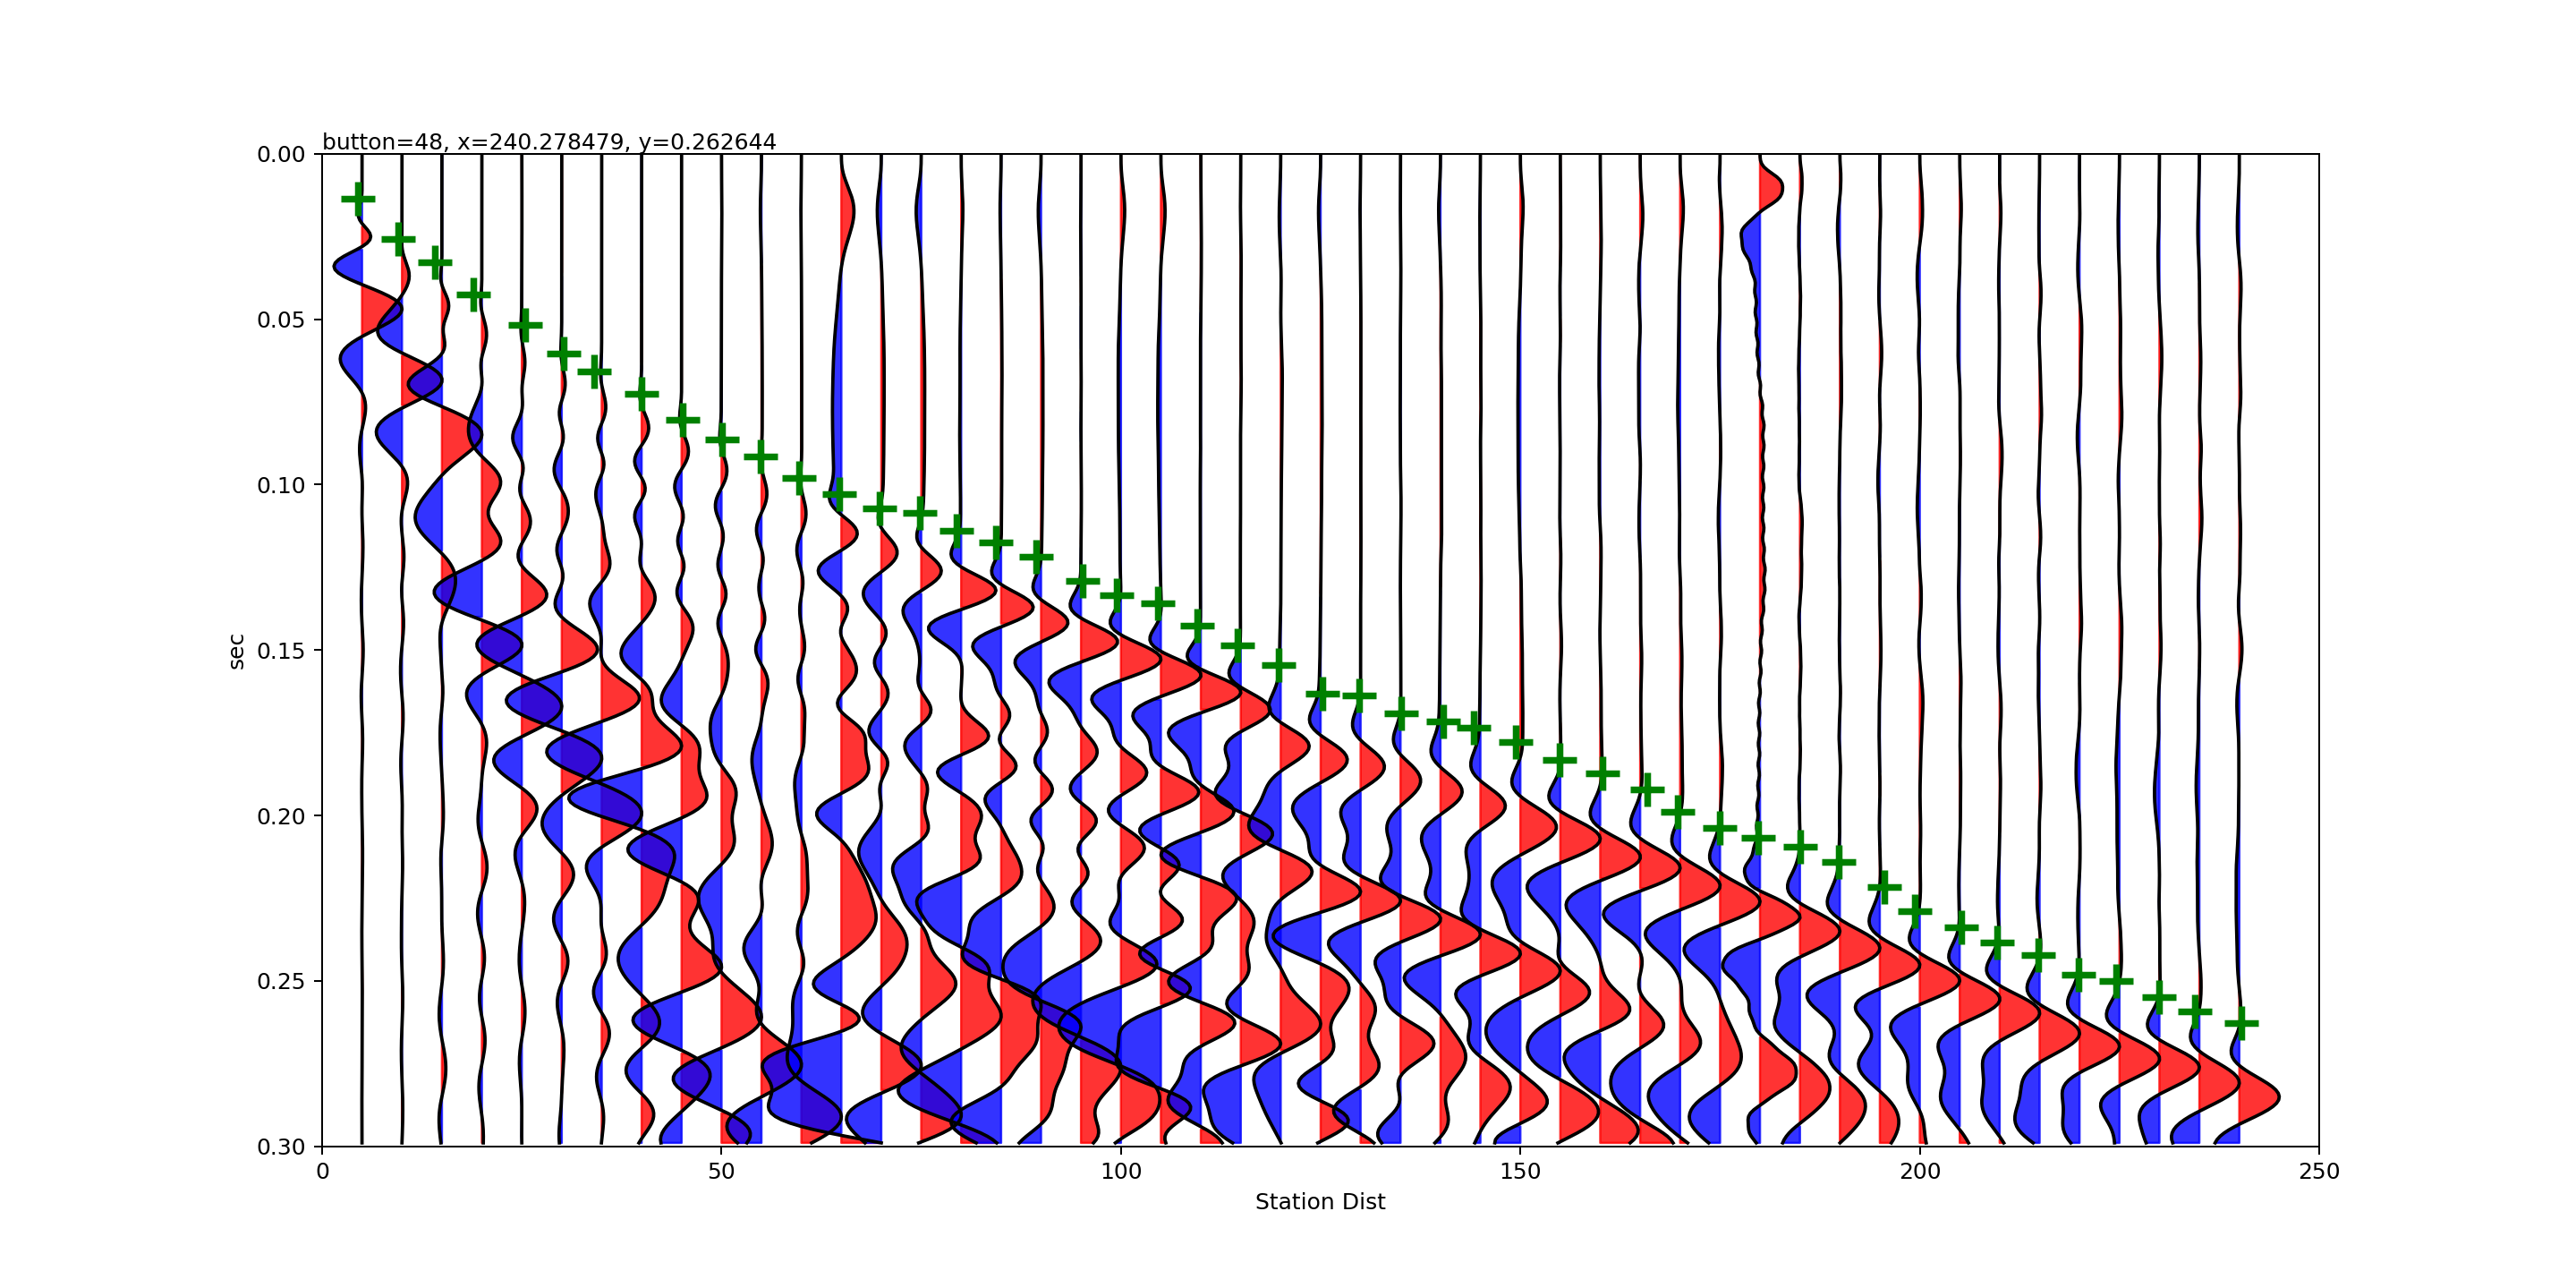

In [159]:
picks=[]
fig, ax =plotseis(seis1,doublecolor=True)
filename='tt1.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


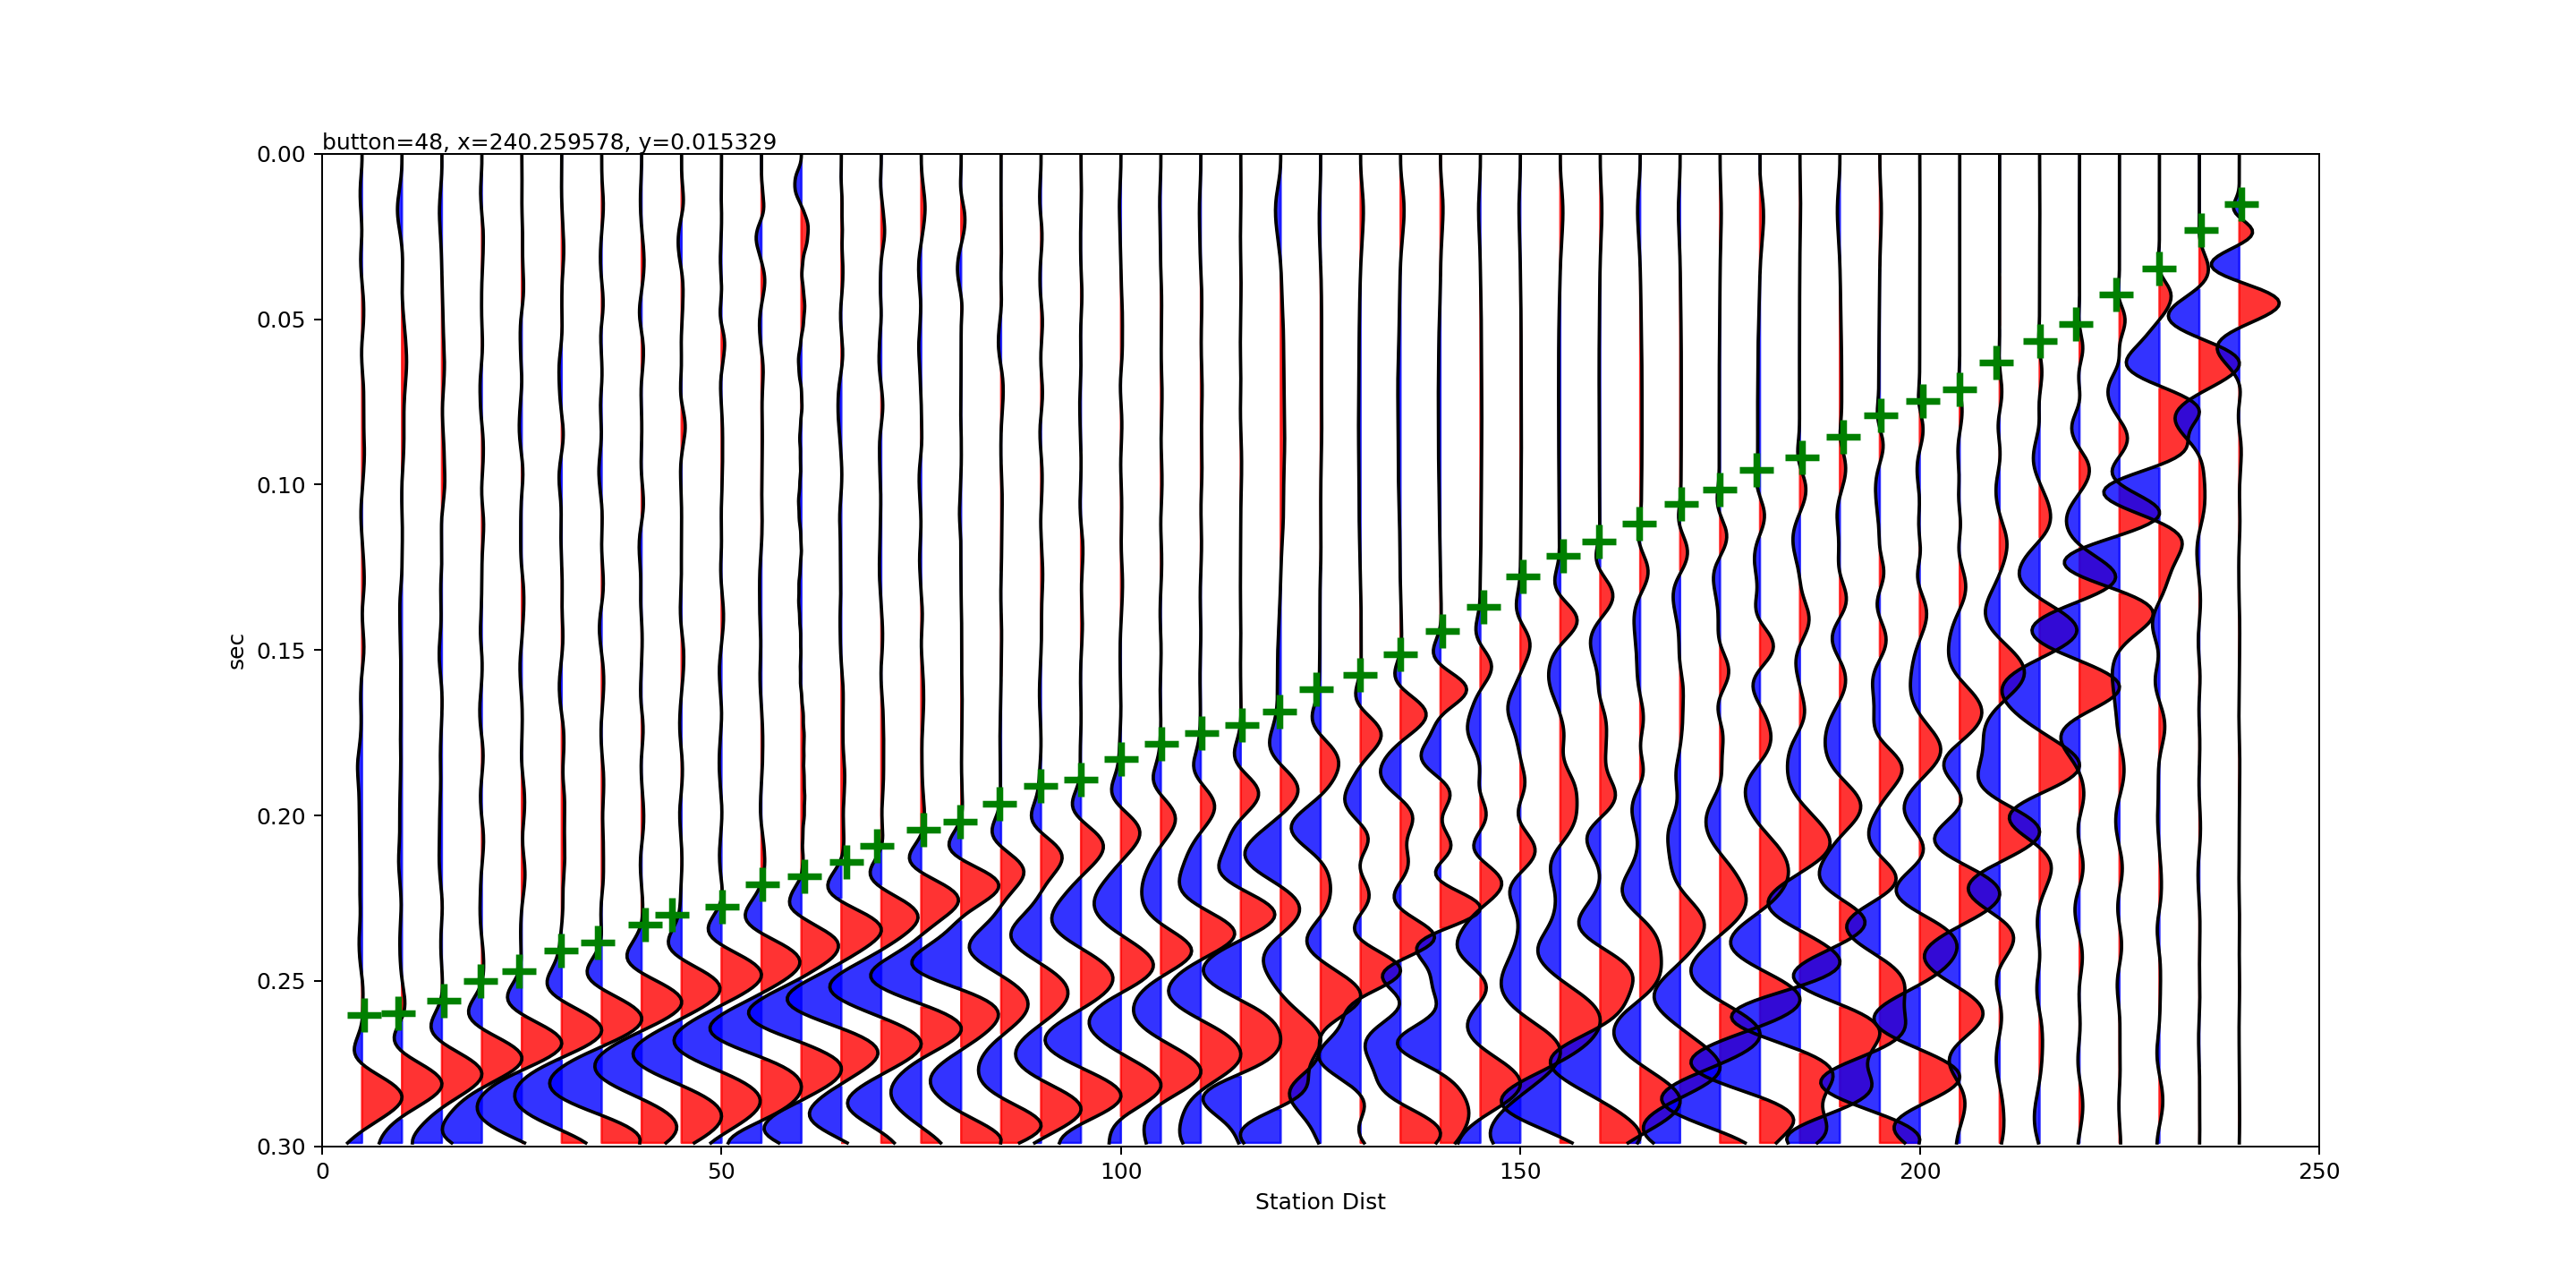

In [34]:
picks=[]
fig, ax =plotseis(seis2,doublecolor=True)
filename='tt2.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


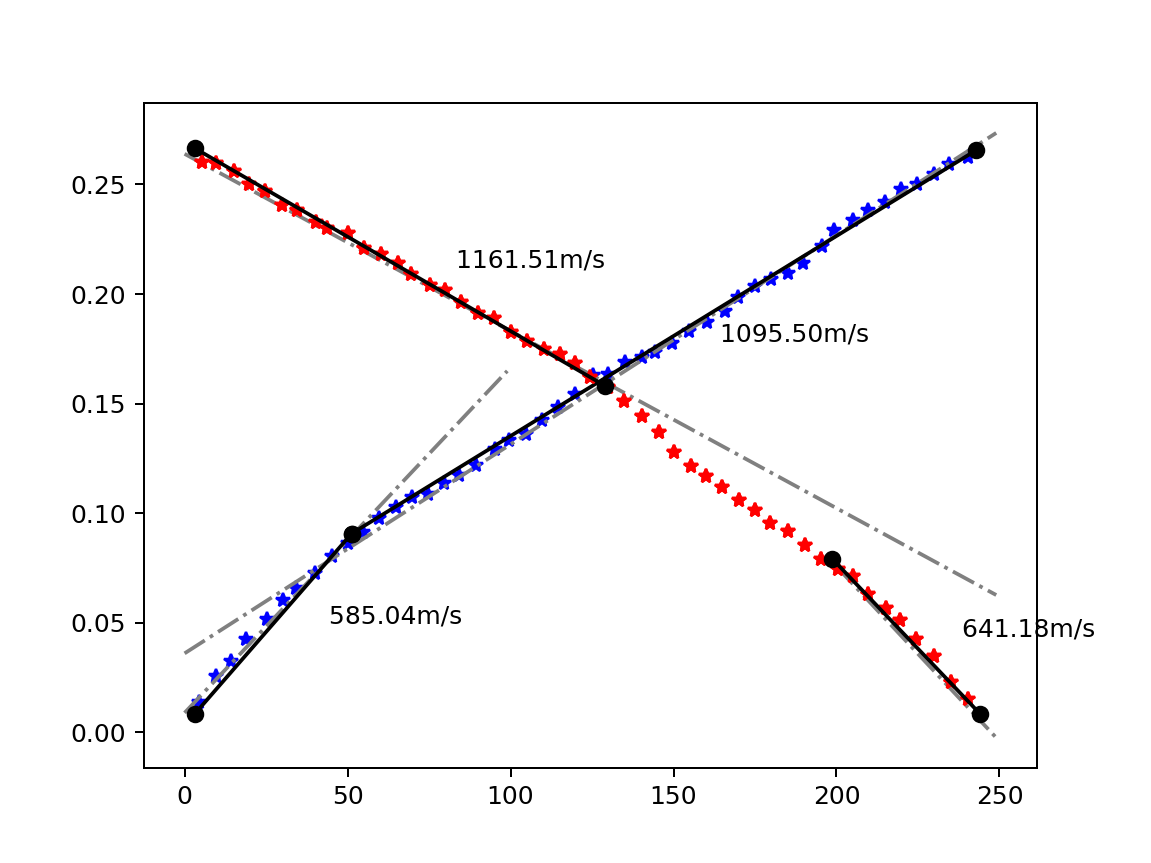

In [201]:
# Keep track of x/y coordinates
lines = []
xcoords = []
ycoords = []
tint=[]
vr=[]
def onclick2(event):
    xcoords.append(event.xdata)
    ycoords.append(event.ydata)
    ax.plot(event.xdata,event.ydata,'ko')
    if len(xcoords)==2:
        lines.append(ax.plot(xcoords,ycoords,'k-'))
        x,y=lines[-1][0].get_data()
        p = np.polyfit(x,y, 1)
#         print(p)
        if len(lines)<=nb:
            tint.append(np.polyval(p,0))
        else:
            tint.append(np.polyval(p,rlength))

        vr.append(1/p[0])
        ax.text(np.average(xcoords),np.average(ycoords),'       %.2f'%(abs(1/p[0]))+'m/s')
        xcoords[:] = []
        ycoords[:] = []
    if len(lines)==nb:
        plt.plot(abs(tt2[:,0]),tt2[:,1],'r*')
    # Refresh the plot
    fig.canvas.draw()


fig, ax = plt.subplots()

tt1=np.load('tt1.npy')
tt2=np.load('tt2.npy')

plt.plot(abs(tt1[:,0]),tt1[:,1],'b*')

connection_id = fig.canvas.mpl_connect('button_press_event', onclick2)
# fig.canvas.mpl_connect('pick_event', onpick)
# lines[0][0].get_data()

# support lines
# uncomment the following lines to help you select segments
# vr0 =[634.73861525922655,1048.6892708921835, -627.18220317280736, -1237.0978517643391]

# tint0=[0.0089297108247262409,0.036057618376078973,0.011924472761510874, 0.069949313322914708]

# plt.plot(np.arange(100),np.arange(100)/vr0[0]+tint0[0],'-.',color='gray')
# plt.plot(np.arange(250),np.arange(250)/vr0[1]+tint0[1],'-.',color='gray')

# plt.plot(np.arange(200,250),np.arange(200,250)/vr0[2]+tint0[2]- 240/vr0[2],'-.',color='gray')
# plt.plot(np.arange(250),np.arange(250)/vr0[3]+tint0[3]-240/vr0[3],'-.',color='gray')

<IPython.core.display.Javascript object>


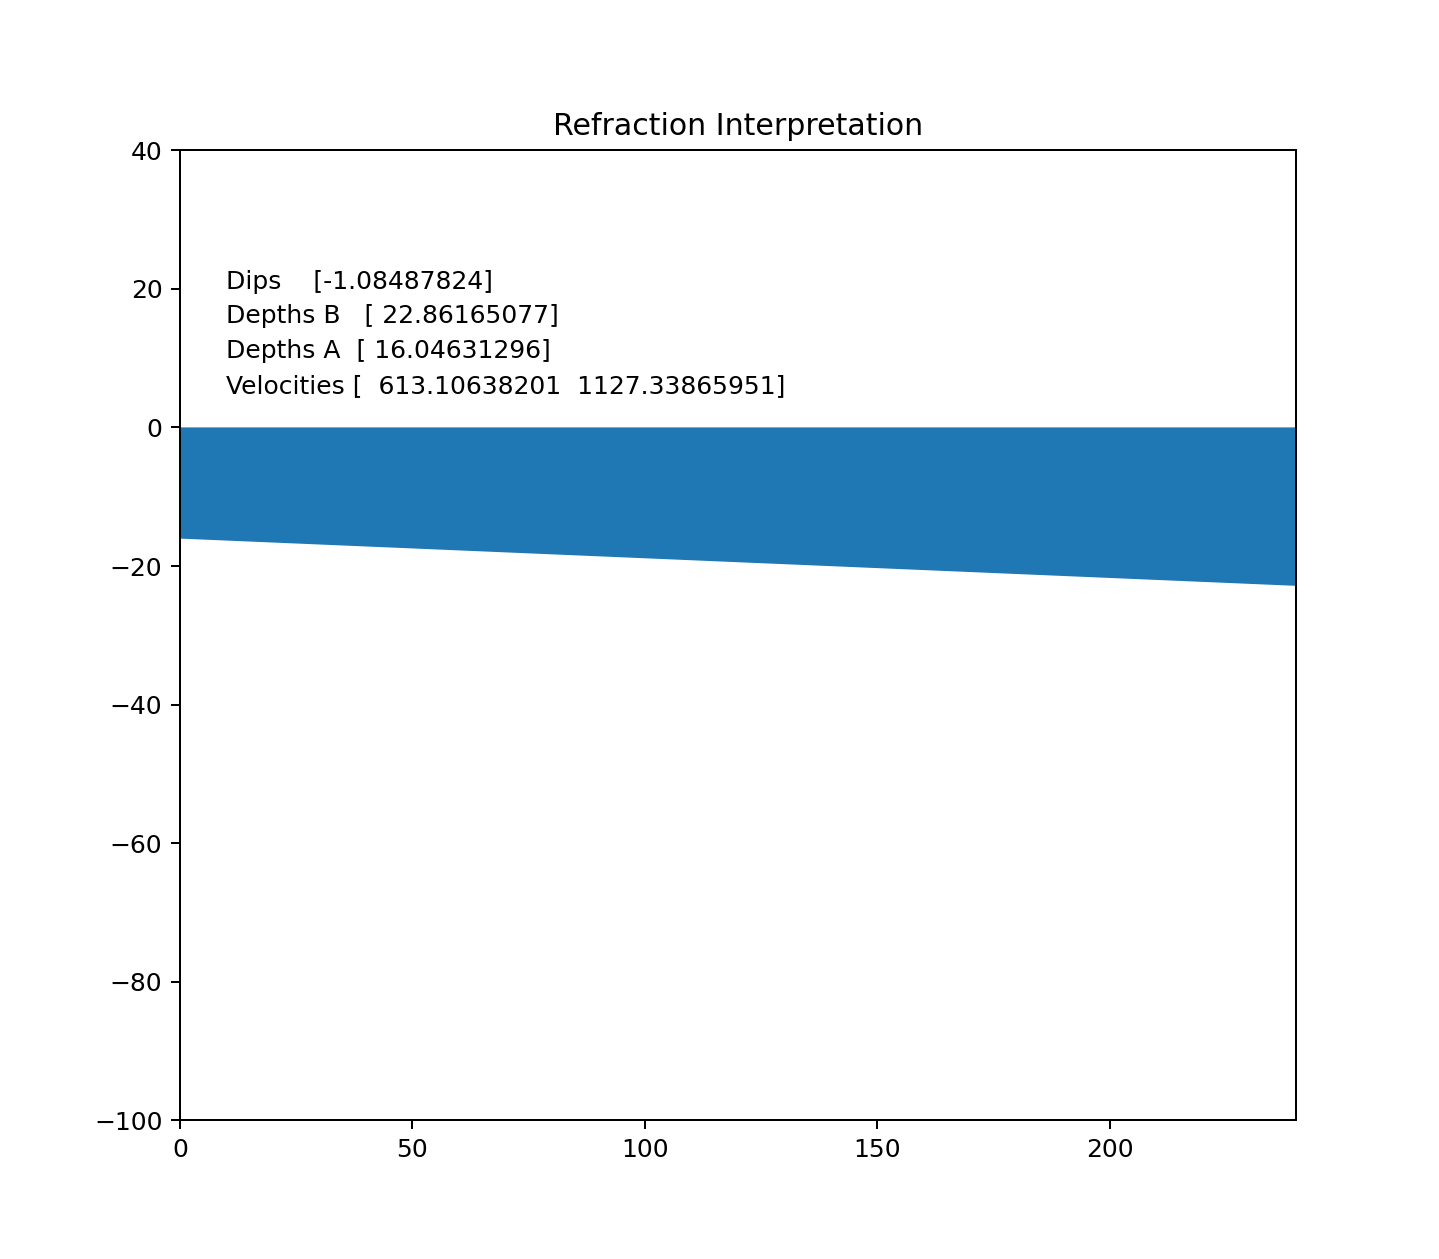

(-100.0, 40.0)

In [202]:
# Testing dataset
# nb=3
# vr =    [0.5297 , 0.8713,    1.1765,
#     -0.5320 ,  -0.9035,   -1.4092]

# tint =  [ -0.0026 ,   0.0284 ,   0.0635,
#      0.0012 ,   0.0412,    0.0958]
# rlength=235


# vr=np.array(vr).reshape((2,-1))*1e3

n=nb                # layers
x=rlength           # length

vr=np.array(vr).reshape((2,-1))
tint=np.array(tint).reshape((2,-1))

tforward=tint[0,-1]+rlength/vr[0,-1]
treverse=tint[1,-1]-rlength/vr[1,-1]
if abs(tforward-treverse)> 0.02:
    print(str(abs(tforward-treverse))+ 'is too big!')
    print('Non Reciprocal DO Previous Step again')


v=np.zeros(n)
w=np.zeros(n)
alph=np.zeros(n-1)
beta=np.zeros(n-1)
a=np.zeros(n-1)
p=np.zeros(n-1)
q=np.zeros(n-1)
ha=np.zeros(n-1)
hb=np.zeros(n-1)
da=np.zeros(n-1)
db=np.zeros(n-1)


va= vr[0,:nb]
vb=-vr[1,:nb]
tai=tint[0,:nb]
tbi=tint[1,:nb]
tai[0]=0
tbi[0]=0

va[0]=(va[0]+vb[0])/2
vb[0]=va[0]

v[0] = (va[0] + vb[0])*0.5

for m in range(1,n):
    k = 0
    alph[0] = math.asin(v[0]/vb[m])
    beta[0] = math.asin(v[0]/va[m]) 
#     print(vb[m],va[m],alph,beta)
    if m==1:     
        a[0] = (alph[0] + beta[0]) * 0.5 
        w[1] = (alph[0] - beta[0]) * 0.5 
        v[1] = v[0]/np.sin(a[0])
    if m>1:
        while k < 100:
            print('k',k)
            a[0] = alph[0] - w[1] 
            b[0] = beta[0] + w[1] 
            k = k+1 
            vv = v[k]/v[k-1] 
            p[k] = math.asin(vv*math.sin(a[k-1])) 
            q[k] = math.asin(vv*math.sin(b[k-1])) 
            if(k+1-m) >=0: 
                break
            a[k] = p[k] - w[k+1] + w[k] 
            b[k] = q[k] + w[k+1] - w[k]
            alph[k] = a[k] + w[k+1] 
            beta[k] = b[k] - w[k+1] 
      
        a[k] = (p[k] + q[k]) * .5;
        b[k] = a[k]
        w[k+1] = w[k] + (p[k] - q[k]) * .5 ;
        alph[k] = a[k] + w[k+1] 
        beta[k] = b[k] - w[k+1]
        v[k+1] = v[k]/math.sin(a[k]);
        
    kk = k-1 
    hha = 0.0 
    hhb = 0.0 
      
    if kk>=0:  
        for i in range(kk+1):
            hh = math.cos(alph[i]) + math.cos(beta[i])
            hh = hh/v[i] 
            hha = hha + hh*ha[i]
            hhb = hhb + hh*hb[i]
            
    r = v[k]/(math.cos(alph[k]) + math.cos(beta[k]))
    ha[k] = r*(tai[k+1] - hha) 
    hb[k] = r*(tbi[k+1] - hhb)
    da[0] = ha[0] 
    db[0] = hb[0] 
      
    if k-1 >= 0:
        da[k] = da[k-1] + ha[k] 
        db[k] = db[k-1] + hb[k]
        
for j  in range(1,n) :
      w[j] = w[j]*57.2958 + 0.001 

        
plt.figure(figsize=(8,7))

for i in range(n-2,-1,-1):
    plt.fill_between([0,rlength,rlength,0],[0,0,-db[i],-da[i]],1)
plt.text(0+10,5,'Velocities '+str(v[:n]))
plt.text(0+10,10,'Depths A  '+str(da[:n-1]))
plt.text(0+10,15,'Depths B   '+str(db[:n-1]))
plt.text(0+10,20,'Dips    '+str(w[1:n]))
plt.title ('Refraction Interpretation')

plt.xlim([0,rlength])
plt.ylim([-100,40])


<IPython.core.display.Javascript object>


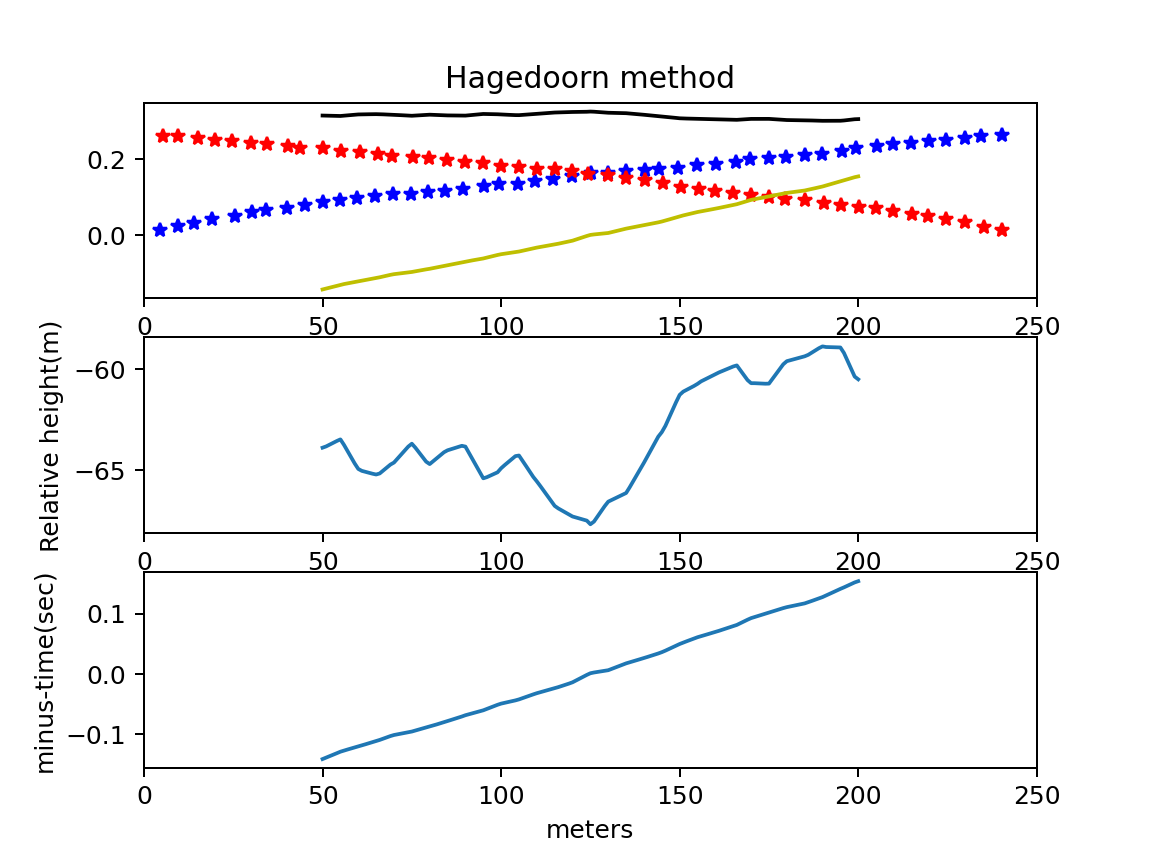

1025.2539846782697

In [206]:
tt1=np.load('tt1.npy')
tt2=np.load('tt2.npy')
dx=1
v1=613   #567
v2=1127  #1008
ttotal=(tt1[-1,1]+tt2[-1,1])/2; #Use the average of 2 end points as t_total.

fact=v1*v2/math.sqrt(v2**2-v1**2)/2; #equation 6.12 in the textbook
ix2=range(50,201)  
f1=interp1d(tt1[:,0],tt1[:,1])
t1=f1(ix2)
f2=interp1d(tt2[:,0],tt2[:,1])
t2=f2(ix2)

tplus2=t1+t2
tminus2=t1-t2
plt.figure()
plt.subplot(3,1,1)
plt.title ('Hagedoorn method')
# See figure 6.18 to understand the Plus-minus plots.
plt.plot(abs(tt1[:,0])*dx,tt1[:,1],'b*')
plt.plot(abs(tt2[:,0])*dx,tt2[:,1],'r*')

plt.plot(ix2,tplus2,'k')
plt.plot(ix2,tminus2,'y')
plt.xlim([0,250])
plt.subplot(3,1,2)
# Plot the relative height of the interface. Use surface as referance. 
plt.plot(ix2,-(tplus2-ttotal)*fact)    #-mean(-(tplus2-ttotal)*fact))
plt.xlim([0,250])
plt.ylabel('Relative height(m)')
plt.subplot(3,1,3)
# The slope of tf-tr should be equal to 2/v2
plt.plot(ix2,tminus2)
plt.xlim([0,250])
plt.xlabel('meters')
plt.ylabel('minus-time(sec)')
P=np.polyfit(ix2,tminus2,1)
2/P[0]